In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [11]:
# Define constants
BATCH_SIZE = 32
IMG_SIZE = (86, 86)
EPOCHS = 12
DATASET_PATH = "../Dataset"

In [12]:
# Load datasets for binary classification
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"  # Binary classification
)

Found 84898 files belonging to 2 classes.
Using 67919 files for training.


In [13]:
val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"  # Binary classification
)

Found 84898 files belonging to 2 classes.
Using 16979 files for validation.


In [14]:
# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
# Data preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255)  # Normalizing the pixel values
])

In [16]:
from tensorflow.keras import layers, models

# Build the model
model = models.Sequential([
    resize_and_rescale,  # Assuming resize_and_rescale is a preprocessing layer

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.4),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Build the model with input shape
model.build(input_shape=(None, 86, 86, 3))

# Model Summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 86, 86, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 43, 43, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 43, 43, 64)        18496     
                                                      

In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [18]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

Epoch 1/12


2123/2123 [==============================] - 184s 86ms/step - loss: 0.2282 - accuracy: 0.9066 - val_loss: 0.1177 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 2/12
2123/2123 [==============================] - 158s 75ms/step - loss: 0.0987 - accuracy: 0.9652 - val_loss: 0.0623 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 3/12
2123/2123 [==============================] - 87s 41ms/step - loss: 0.0784 - accuracy: 0.9726 - val_loss: 0.0516 - val_accuracy: 0.9851 - lr: 0.0010
Epoch 4/12
2123/2123 [==============================] - 87s 41ms/step - loss: 0.0724 - accuracy: 0.9749 - val_loss: 0.0545 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 5/12
2123/2123 [==============================] - 87s 41ms/step - loss: 0.0634 - accuracy: 0.9777 - val_loss: 0.0449 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 6/12
2123/2123 [==============================] - 87s 41ms/step - loss: 0.0582 - accuracy: 0.9798 - val_loss: 0.0405 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 7/12
2123/2123 [==============================] -

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

531/531 [==============================] - 8s 14ms/step - loss: 0.0345 - accuracy: 0.9884
Validation Loss: 0.03454333543777466
Validation Accuracy: 0.9883974194526672


In [20]:
model.save("../Models/model2.h5")

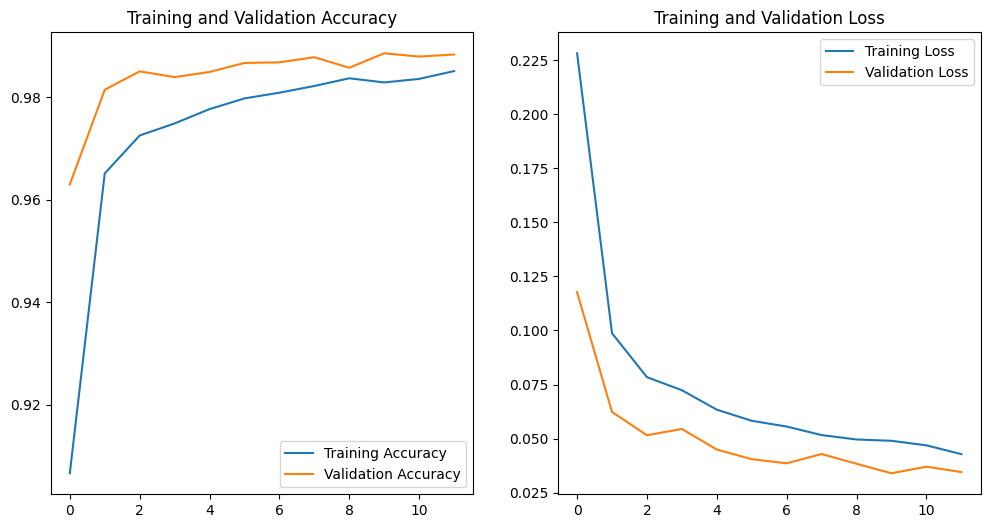

In [21]:
import matplotlib.pyplot as plt

# Extract metrics from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


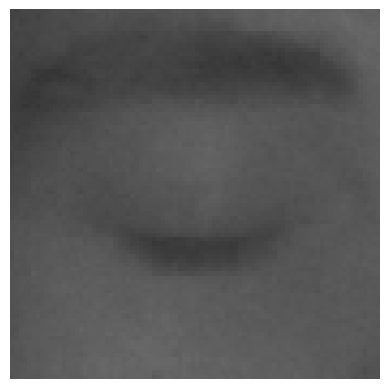

1/1 [==============================] - 0s 27ms/step
Predicted label: Close-Eyes


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

def predict_and_display_single_image(image_path, class_names, model):
    # Load and preprocess the image
    img = keras_image.load_img(image_path, target_size=(86, 86))  # Resize to match model input size
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize the image

    # Display the input image
    plt.imshow(img_array[0])
    plt.axis('off')
    plt.show()

    # Predict the label
    batch_prediction = model.predict(img_array)
    predicted_label = class_names[np.argmax(batch_prediction[0])]

    print("Predicted label:", predicted_label)

# Example class names
class_names = ['Close-Eyes', 'Open-Eyes']

# Path to the image
image_path = "../Dataset/Close-Eyes/s0001_00102_0_0_0_0_0_01.png"

# Assuming `model` is already loaded
# If not, you can load the model with load_model("path_to_model.h5")

# Predict and display
predict_and_display_single_image(image_path=image_path, class_names=class_names, model=model)
